<a href="https://colab.research.google.com/github/Sen-R/tutorials-dl/blob/master/notebooks/Neural_Networks_in_NumPy_and_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural nets in Numpy and Tensorflow

## Introduction

This is the first in a series of notebooks for getting to grips with how basic supervised learning with a fully connected network can be achieved with TensorFlow.

Unlike some other tutorials, it is intended for the more mathematically minded, as it starts with quite a low level approach to defining and fitting a model, that is close to the maths. Over the course of the lessons this is transformed into use of the high level Keras API for performing the same task in a few lines. The intention is to help the reader understand what is effectively going on under the hood when you fit a model to data using TensorFlow / Keras.

In this first notebook, we will build and train a neural network without using Tensorflow at all: i.e. just using NumPy. In subsequent notebooks we will gradually evolve the code we have written here until it becomes a canonical Keras-based training script for solving the same problem.

## A quick review of the maths

We have been given a set of $n$ tuples $(\mathbf{x}, y)$, where $\mathbf{x}$ is a *feature vector* of observations, and $y$ is the corresponding ground truth for whatever the model is trying to predict given $\mathbf{x}$. The task is to learn from this dataset a function $f(\mathbf{x})$ that "best" estimates $y$.

We learn $f$ by first settling on a *loss function* $L(y_, y_\mathrm{pred})$ that quantifies the "badness" of a prediction of $y$ with respect to its actual value: i.e. $L$ is minimised when $y = y_\mathrm{pred}$. We would like to learn a function $f$ that yields a low expected loss on new (unseen) examples.

A neural network models $f$ by a sequence (or more generally a directed acyclic graph) of function compositions. Typically the functions that are composed either consist of affine transformations or the pointwise application of a nonlinearity.

For any such fixed neural network architecture ("model"), there will be an associated set of model parameters, such as the weights of the affine transformations. We may represent the network as $f_\theta(\mathbf{x})$, where $\theta$ collectively represents these model parameters. The process of training a network thus becomes the process of finding a good set of model parameters $\theta$ that yields a low average loss. Taking the mean loss on the training set as an estimator for the expected loss on unseen examples, we may therefore look to solve the following optimisation problem:

$$ \hat{\theta} = \arg\min_{\theta\in\Theta} \sum_{i=1}^{n} L(y_i, f_\theta(\mathbf{x}_i))$$

One challenge with this approach is that, once the training data has been used to search for an optimal $\theta$, the average loss on the training set is no longer an unbiased estimator of the expected loss on unseen examples: it will usually be an underestimate. This is the problem of model *overfitting*. Nevertheless, this is what we will do, albeit with certain tricks to try and find a "good" minimum that is likely to generalise well.

Since the functions that make up the network are differentiable in their parameters, we typically use gradient based optimisation to search for a good (i.e. locally optimal) set of parameters. The simplest search algorithm is gradient descent: this involves applying the following iteration to the model parameters:

$$ \theta \mapsto \theta - \eta \frac{\partial}{\partial \theta} \sum_{i=1}^n L(y_i, f_\theta(\mathbf{x}_i))$$

where the optimisation parameter $\eta$ is called the learning rate.

For large datasets, models and / or feature vectors, it may be computationally expensive to compute the gradient over all examples. So it is common to randomly partition the training set into smaller *batches* of examples, using a different batch to estimate the gradient at each step of gradient descent. The typical approach is to draw batches without replacement until all examples in the dataset have been used (an "epoch") before starting the process once again.

This approach is called *stochastic* gradient descent. It has an advantage that goes beyond computational tractibility which means it is also often useful for smaller problems: by using a random subsample we introduce randomness into the estimation of gradients. This should typically help with avoiding overfitting: intuitively, an optimum that can be approached despite the addition of noise in the search trajectory is more likely to be "wide and deep", i.e. a generally good solution rather than one that is fine tuned to the specific examples in the training set.

How can we define and train a neural network? The discussion above suggests the following key steps:

1. Define a neural network architecture, i.e. a function $f_\theta$ that maps feature vectors $\mathbf{x}$ to predicted outputs $y_\mathrm{pred}$;
2. Define a loss function to evaluate the outputs $y_\mathrm{pred}$;
3. Provide methods to calculate the gradient of the average loss with respect to model parameters;
4. Implement an optimiser (such as stochastic gradient descent) that uses these gradients to update model parameters in a direction that improves the loss;
5. Implement a training loop that runs the loss gradient calculation and optimisation step repeatedly until some termination condition is satisfied.

## Synthetic dataset

We begin by generating synthetic data for the exercise. Examples are generated using the following "true" model:

$$y = 3 + 2 x_0 + 5 x_1 + \varepsilon$$

To generate some data, we sample $\mathbf{x} = [x_0, x_1]$ from a uniform random distribution.

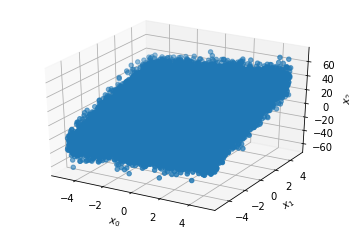

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def draw_X(n_samples, seed):
    """Generates `n_samples` sample feature vectors by drawing from a 2D
    uniform distribution"""
    np.random.seed(seed)
    return np.random.uniform(-5, 5, size=(n_samples, 2))

def draw_y_given_X(X, seed, noise_amplitude=None):
    """Generates random values for y given the feature vectors `X`
    according to the "true" model"""
    w = np.array([[2.], [5.]])
    b = 3.
    np.random.seed(seed)
    epsilon = np.random.normal(scale=noise_amplitude, size=(X.shape[0], 1))
    return np.matmul(X, w) + b + epsilon

n_samples = 2 ** 15
X = draw_X(n_samples, seed=4321)
y = draw_y_given_X(X, seed=1234, noise_amplitude=10.)
ax = plt.axes(projection = "3d")
ax.scatter(X[:, 0], X[:, 1], y)
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.set_zlabel("$x_2$");

## Iteration 1: Deep learning just using NumPy

To start our journey, let's first consider what would we do if TensorFlow (or equivalents like PyTorch) didn't exist. I.e., let's first code our implementation just using NumPy.

To do this we need to code up the following:
* A model function (with model parameters that we will train)
* A loss function
* A gradient descent optimiser
* A training loop that puts these together and finds (locally) optimal parameters for the model.

In order to implement gradient descent, we will need to calculate gradients with respect to the model parameters. Since we are working in NumPy, these too will needed to be derived and coded up by hand (you are encouraged to check the maths).

### 1.1 The model

Let's begin by defining a `Model` class. This has the following key attributes:
* A `__call__` method, to evaluate the model on a batch of input feature vectors;
* A `gradients` method, to return the gradients with respect to the model parameters (used to perform gradient descent).

In [14]:
class Model:
    """ Linear model class """
    def __init__(self, initial_weights, initial_biases):
        """Initialise the model with given weights and biases"""
        # Validate inputs shapes.
        assert len(initial_weights.shape) == 2
        assert len(initial_biases.shape) == 1
        assert initial_weights.shape[1] == initial_biases.shape[0]

        # Assign to model weights
        self.weights = initial_weights
        self.biases = initial_biases

    @property
    def trainable_weights(self):
        return (self.weights, self.biases)

    def __call__(self, X):
        """Calculate outputs given matrix of features X"""
        # Validate input
        assert len(X.shape) == 2
        # Return prediction
        return np.matmul(X, self.weights) + self.biases[np.newaxis, :]

    def gradients(self, v, X):
        """Return gradients of outputs with respect to model parameters.
        
        `v` should be a tensor with the same dimensions as the output of
        the model, and this function will return contractions of `v` with
        the model's gradients. I.e. it will return the tuple:

        `(\sum_{ij} v_{ij} df_{ij} / dw_{km}, \sum_{ij} v_{ij} df_{ij} db_k)`

        where `w_{km}` and `b_{m}` are the model's weights matrix and bias
        vector respectively.

        You can do the maths to check the derivatives implemented below are
        correct.
        """
        # Validate input
        assert len(X.shape) == 2
        assert X.shape[1] == self.weights.shape[0]
        assert len(v.shape) == 2
        assert v.shape[1] == self.weights.shape[1]
        # Return gradients
        return np.matmul(X.T, v), np.sum(v, axis=0)

Note that we could have added another method for returning the model's derivative with respect to its inputs. This is required to backpropagate gradients to shallower layers when linear layers like this one are stacked to make a deep network. But this gradient isn't required for this single-layer exercise.

### 1.2 The loss function

Next we define a mean squared error loss function $L(\mathbf{y}_\mathrm{true}, \mathbf{y}_\mathrm{pred})$.

As with `Model`, this class has `__call__` and `gradients` methods for evaluating the loss and calculating gradients with respect to predictions ($\partial L / \partial \mathbf{y}_\mathrm{pred}$).

In [15]:
class MSELoss:
    def __call__(self, y_true, y_pred):
        """ Evaluate mean squared error over batch"""
        self._validate_inputs(y_true, y_pred)
        return np.mean((y_pred - y_true) ** 2, axis=None)

    def gradients(self, y_true, y_pred):
        """ Return gradients of mse loss with respect to y_pred """
        self._validate_inputs(y_true, y_pred)
        return (2. / len(y_true)) * (y_pred - y_true)

    def _validate_inputs(self, y_true, y_pred):
        assert y_true.shape == y_pred.shape
        assert len(y_true.shape) == 2

### 1.3 The optimizer

Now we define a gradient descent optimizer. In keeping with TensorFlow convention, it has a method called `apply_gradients` that will apply a single gradient descent step to the model weights that have been provided.

In [16]:
class SGD:
    """ Simple implementation of SGD """
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def apply_gradients(self, grad_weight_pairs):
        """ Use gradient descent to update weights given gradients """
        for gradients, weights in grad_weight_pairs:
            assert gradients.shape == weights.shape
            weights -= self.learning_rate * gradients

### 1.4 The training loop

Next, we write a function that implements a training loop to train the model on the sample data.

In [17]:
def train(X, y, model, loss_fn, optimizer, epochs=1):
    losses = []
    for _ in tqdm(range(epochs)):
        # Compute loss
        y_pred = model(X)
        loss = loss_fn(y, y_pred)

        # Compute and backpropagate gradients
        loss_grads = loss_fn.gradients(y, y_pred)
        grads = model.gradients(loss_grads, X)
    
        # Append current loss to history
        losses.append(loss)

        # Take gradient descent step
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return losses

### 1.5 Putting it all together

Finally we are able to train the model on the training data. Training pretty much converges to the true model parameters in 40 iterations:


Trained model weights:
  w: [1.99305852 4.9608497 ]
  b: 3.0494662002240753

Training history:


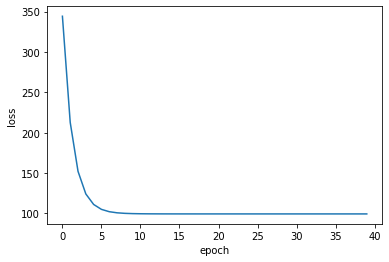

Residuals:


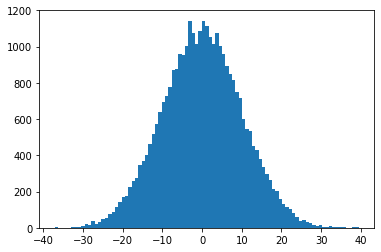

In [18]:
# Initialise model weights
np.random.seed(42)
initial_w = np.random.normal(size=(2, 1))
initial_b = np.array([0.])

# Create model, loss function and optimizer objects
model = Model(initial_w, initial_b)
loss = MSELoss()
optimizer = SGD(learning_rate=0.1)

# Run training loop
history = train(X, y, model, loss, optimizer, epochs=40)

# Print trained weights
print("Trained model weights:")
for name, value in zip(["w", "b"], model.trainable_weights):
    print(f"  {name}:", value.squeeze())

# Plot loss as function of epoch number
print("\nTraining history:")
plt.figure()
plt.plot(history)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# Plot residuals to verify model fit
def plot_residuals(y_true, y_pred, ax=None):
    errors = y_pred - y
    if ax is None:
        _, ax = plt.subplots(1, 1)
    ax.hist(errors, bins="auto")

print("Residuals:")
plot_residuals(y, model(X));

### 1.6 Parting thoughts

We have implemented a (very simple!) neural network and trained it using gradient descent purely using NumPy. Let's take a moment to consider some of the difficulties we have to overcome with this approach, particularly as we think about implementing more complex network architectures:

* We had to calculate derivatives for each component by hand. This is both tedious and error prone.
* We had to separately chain together the forward pass (loss function evaluation) and backward pass (gradient computation) steps. Again this is error prone, particularly as we generalise to more complicated architectures. Wouldn't it be good if the computer could keep track of the operations that made up the forward pass (which can be represented by a *directed acyclic graph*) and automatically flow gradients back the same graph of operations for the backward pass?
* Neural networks computations (both forward and backward passes) are typically made up of repeated matrix multiplications and additions. Especially as we move to training large networks on large feature vectors it may be more efficient to perform these calculations on hardware better optimised for such operations -- e.g. GPUs or even TPUs. NumPy does not provide for such acceleration.

In the next iteration, we will see how Tensorflow, at its most basic level, helps us overcome these challenges.

## Iteration 2: NumPy to TensorFlow

In the previous iteration, we built and trained a simple linear network on our synthetic dataset using gradient descent, purely using NumPy. In this iteration we will make minimal changes to our code to instead take advantage of TensorFlow.

At this stage we will not use any of the high level conveniences of TensorFlow or the even higher level Keras API. Instead, we will show how a low level implementation of the network in TensorFlow looks remarkably similar to the NumPy implementation of the previous iteration, except that - just by using TensorFlow rather than NumPy - we can overcome the drawbacks identified at the end of iteration one:

* TensorFlow allows us to automatically take advantage of hardware acceleration to speed up tensor operations;
* TensorFlow can automatically calculate derivatives for our model and loss function, removing the need to do the calculus by hand and the risk of introducing errors;
* TensorFlow keeps track the graph representing the calculations leading up to evaluating the loss on the batch (the "forward pass") and so can effortlessly reverse the graph to flow gradients back to the model parameters (the "backward pass").

So to sum up, in this iteration we will make small changes to the code from our first NumPy iteration to take advantage of these features of TensorFlow.

Before starting, it is worth pointing out the key objects in TensorFlow that are used in this lesson:
* `tf.constant` returns Tensor objects. These can be manipulated using an API that is remarkably similar to NumPy's API for manipulating arrays, except that the memory backing Tensors can be on GPUs / TPUs and that operations can be tracked and gradients automatically calculated.
* `tf.Variable` also returns Tensor-like objects. The difference is that Variables' values may be updated, and derivatives with respect to Variables may be tracked (if the attribute `trainable` is set to `True`). Therefore Variables are typically used to store model parameters.
* `tf.GradientTape` is an object that watches the tensor operations that take place within its scope and is able to return on request derivatives with respect to watched Variables. This is the magic ingredient that means we no longer need to compute derivatives of individual components by hand or chain them together in the right order to perform the backward pass during the training loop.

### 2.1 The model

First we define the linear model that we need to train. Unlike the NumPy version, we no longer need to define a `gradients` method as TensorFlow's `GradientTape` will take care of that. Otherwise though, it looks remarkably similar:

In [19]:
import tensorflow as tf

class Model:
    """ Linear model class """
    def __init__(self, initial_weights, initial_biases):
        """Initialise the model with given weights and biases"""
        # Validate inputs shapes.
        tf.debugging.assert_shapes([
            (initial_weights, ("F", "O")), (initial_biases, ("O",))
        ])

        # Assign to model weights
        self.weights = initial_weights
        self.biases = initial_biases

    @property
    def trainable_weights(self):
        return (self.weights, self.biases)

    def __call__(self, X):
        """Calculate outputs given matrix of features X"""
        # Validate input
        tf.debugging.assert_shapes([
            (X, ("N", "F")), (self.weights, ("F", "O"))
        ])
        # Return prediction
        return tf.matmul(X, self.weights) + self.biases[tf.newaxis, :]

### 2.2 The loss function

Again we adapt the NumPy implementation. The result is very similar except we lose the `gradients` method, making this a very simple object.

In [20]:
class MSELoss:
    def __call__(self, y_true, y_pred):
        """ Evaluate mean squared error over batch"""
        tf.debugging.assert_shapes([
            (y_true, ("N", "O")), (y_pred, ("N", "O"))
        ])
        return tf.reduce_mean(tf.square(y_pred - y_true), axis=None)

### 2.3 The optimizer

This is almost identical to the NumPy implement, except we need to remember to use the `assign` method (or its `assign_add` and `assign_sub` relatives)to update the value of `tf.Variable`. Simply subtracting from a `Variable` results in a plain Tensor, which will cause auto-differentiation to fail.

In [21]:
class SGD:
    """ Simple implementation of SGD """
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def apply_gradients(self, grad_weight_pairs):
        """ Use gradient descent to update weights given gradients """
        for gradients, weights in grad_weight_pairs:
            assert gradients.shape == weights.shape
            weights.assign_sub(self.learning_rate * gradients)

### 2.4 The training loop

We begin with the NumPy training loop. The key difference here is in the backpropagation step. By watching the gradients using `tf.GradientTape` during the forward pass, we effortlessly derive the gradients for the backward pass.

In [22]:
def train(X, y, model, loss_fn, optimizer, epochs=1):
    losses = []
    for _ in tqdm(range(epochs)):
        # Compute loss
        with tf.GradientTape() as tape:
            # Operations within scope are watched by tape
            # so that gradients can be calculated during
            # backprop step
            tape.watch(model.trainable_weights)
            y_pred = model(X)
            loss = loss_fn(y, y_pred)

        # Compute and backpropagate gradients
        grads = tape.gradient(loss, model.trainable_weights)
    
        # Append current loss to history
        losses.append(loss)

        # Take gradient descent step
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return losses

### 2.5 Putting it all together

Having defined these components, the training script for training the TensorFlow version of the model is almost identical. The main difference is that we initialise the weights as `tf.Variable` and that we need to convert the dataset `(X, y)` from NumPy arrays into Tensors.


Trained model weights:
  w: [1.9930583 4.9608493]
  b: 3.0494654

Training history:


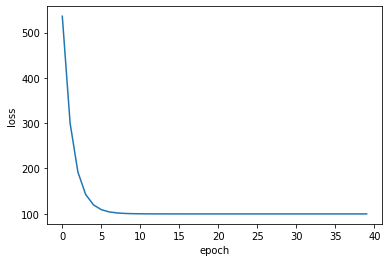

Residuals:


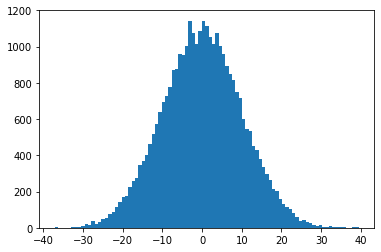

In [23]:
# Initialise model weights
initial_w = tf.Variable(
    tf.random.stateless_normal(shape=(2, 1), seed=[123, 321]), trainable=True, name="weights"
)
initial_b = tf.Variable([0.], trainable=True, name="biases")

# Create model, loss function and optimizer objects
model = Model(initial_w, initial_b)
loss = MSELoss()
optimizer = SGD(learning_rate=0.1)

# Run training loop after converting datasets to Tensors
X_t = tf.constant(X, dtype=tf.float32)
y_t = tf.constant(y, dtype=tf.float32)
history = train(X_t, y_t, model, loss, optimizer, epochs=40)

# Print trained weights
print("Trained model weights:")
for name, value in zip(["w", "b"], model.trainable_weights):
    print(f"  {name}:", value.numpy().squeeze())

# Plot loss as function of epoch number
print("\nTraining history:")
plt.figure()
plt.plot(history)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# Plot residuals to verify model fit
print("Residuals:")
plot_residuals(y_t.numpy(), model(X_t).numpy());

### 1.6 Parting thoughts

In this iteration, we have taken our NumPy implementation and ported it to TensorFlow. By and large the code looks very similar, the key difference being that we have adopted automatic differentiation. The code also automatically takes advantage of hardware acceleration where this is available (and TensorFlow has been set up to use it).

Next, we will see how the TensorFlow library comes with commonly used high level objects, such as Models, Layers, loss functions, optimizers, etc that we can use to design and fit most models in just a few lines of code.

## Iteration 3: High-level TensorFlow and Keras

In the previous iteration, we wrote code that in TensorFlow that looked very similar to our NumPy implementation. Apart from taking advantage of automatic differentiation, we still had to implement our model, loss function, optimizer and training loop by hand.

The TensorFlow library comes with Keras which provides many of these objects for us:

* `tf.Module`, from which `tf.keras.Model` and `tf.keras.Layer` are derived are classes that can represent neural network layers and models. They contain built-in functions for extracting model weights, saving models, etc. Keras comes with a library of standard Layers often used to build neural network, and even some standard model architectures for e.g. computer vision applications. Models can be build from Layers by either subclassing from `tf.keras.Model` or often more conveniently by using the Keras Functional or Sequential APIs.
* `tf.keras.Model` also comes with a standard training loop that can be used for supervised learning. It can be further customised with the use of callbacks. This often obviates the need to write out a custom training loop (although this is still possible).
* Keras also comes a library of common loss functions, metrics and optimizers, including the mean-squared-error loss and SGD optimizer we implemented in previous iterations.

Putting these together, we can define and train the model we implemented in previous iterations in just three lines:

Trained model weights:
  w: [1.9930583 4.9608502]
  b: 3.0494668

Training history:


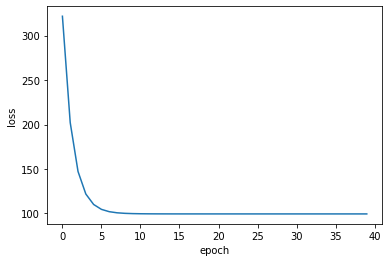

Residuals:


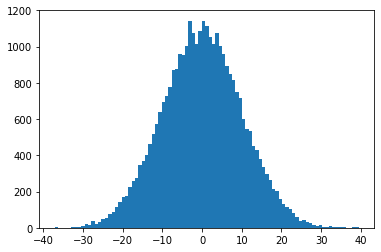

In [24]:
# Create, compile and fit model in just 3 lines
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(2,))])
model.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer=tf.keras.optimizers.SGD(0.1),
)
history = model.fit(X_t, y_t, epochs=40, batch_size=len(X_t), verbose=0)

# Print trained weights
print("Trained model weights:")
for name, value in zip(["w", "b"], model.trainable_weights):
    print(f"  {name}:", value.numpy().squeeze())

# Plot loss as function of epoch number
print("\nTraining history:")
plt.figure()
plt.plot(history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# Plot residuals to verify model fit
print("Residuals:")
plot_residuals(y_t.numpy(), model(X_t).numpy());

## Further resources

* The [TensorFlow website](https://www.tensorflow.org/guide) has user guides for using the Sequential and Functional APIs, creating custom layers and models, writing custom training loops, using callbacks, and much more.